In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


import helper

In [3]:
data = pd.read_csv('../input/preprocessed_data.csv')

data = helper.remove_outliers_z_score(data)
data = data[data['revenue'] != 0]

X = data.drop('revenue', axis=1)
X = helper.data_standardizer(X,8)

y = data['revenue']
y = y.apply(helper.revenue_log)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training fold 1...
Fold 1 trained. validation loss: 3.8169572353363037
Training fold 2...
Fold 2 trained. validation loss: 0.7543371915817261
Training fold 3...
Fold 3 trained. validation loss: 1.6546143293380737
Training fold 4...
Fold 4 trained. validation loss: 0.9425734281539917
Training fold 5...
Fold 5 trained. validation loss: 0.8665995001792908
10/10 [==============================] - 0s 367us/step


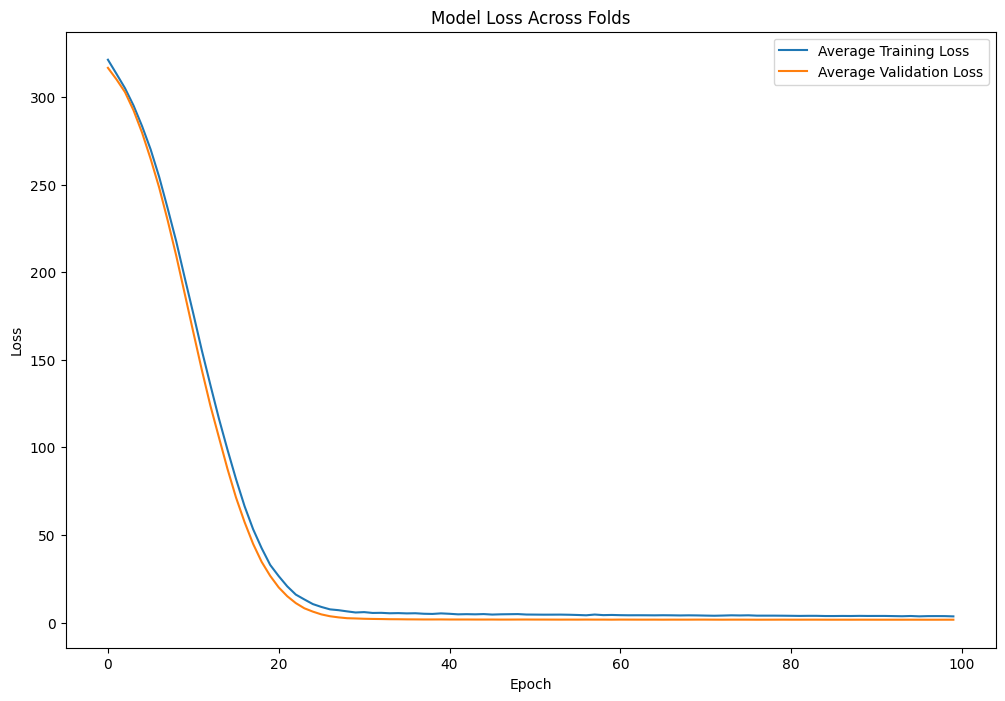

In [4]:


def create_model(input_dim):
    model = Sequential([
        Dense(100, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(50, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(20, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(1) 
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_no = 1
losses = []
val_losses = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model = create_model(X_train.shape[1])

    print(f'Training fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, 
                        epochs=100, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), 
                        verbose=0)

    losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    print(f'Fold {fold_no} trained. validation loss: {history.history["val_loss"][-1]}')
    
    fold_no += 1

avg_loss = np.mean(losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

y_pred = model.predict(X_test)

plt.figure(figsize=(12, 8))
plt.plot(avg_loss, label='Average Training Loss')
plt.plot(avg_val_loss, label='Average Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 4000)              36000     
                                                                 
 batch_normalization_23 (Ba  (None, 4000)              16000     
 tchNormalization)                                               
                                                                 
 dropout_22 (Dropout)        (None, 4000)              0         
                                                                 
 dense_30 (Dense)            (None, 2000)              8002000   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 2000)              0         
                                                                 
 batch_normalization_24 (Ba  (None, 2000)              8000      
 tchNormalization)                                    

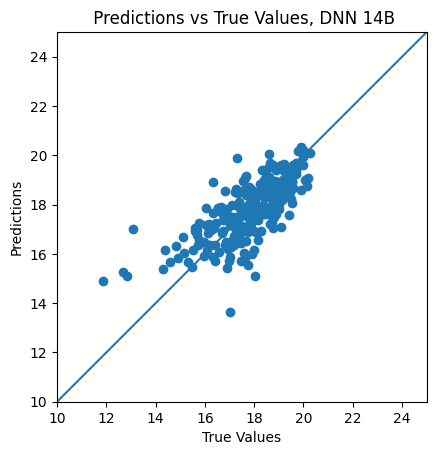

In [6]:

model = Sequential([
    Dense(4000, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(2000),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.4),
    Dense(2000),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1000),
    LeakyReLU(alpha=0.05),
    BatchNormalization(),
    Dropout(0.3),
    Dense(250, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(50, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(50, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(25, activation='relu'),
    BatchNormalization(),
    Dense(1)  # No activation for output layer
])
model.summary()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,  
    validation_data=(X_test, y_test),
    callbacks=[ early_stopping, reduce_lr] #! early_stopping,
)

test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
y_pred = model.predict(X_test)
if (1):
    plt.scatter(y_test, y_pred)
    plt.title(' Predictions vs True Values, DNN 14B')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([10,25])
    plt.ylim([10,25])
    _ = plt.plot([-100, 100], [-100, 100])
else:
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(' DNN 14B Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

ratio = y_test / y_pred.flatten()
print("ratio:", end = "")
print(ratio.describe())